In [23]:
import cv2
import numpy as np
from openpiv import pyprocess, piv
import matplotlib.pyplot as plt
from typing import overload
import numpy as np
import matplotlib.pyplot as plt
from openpiv import tools, pyprocess, scaling, validation, filters
import numpy as np
import glob
import matplotlib.pyplot as plt
import math

# window_size = 32 # pixels, IW size in frame A
# overlap = 16 # 50% overlap
# search_area_size = 32 # pixels, IW in frame B, helps for large displacements
# dt = 0.02 # second, 50 Hz, just an example
# scaling_factor = 96.52 # micron/pixel

In [51]:
# set of typical parameters
window_size = 96# pixels 32 x 32 pixels interrogation window, in frame A.
overlap = 32 # overlap is 8 pixels, i.e. 25% of the window
search_size = window_size # pixels 64 x 64 in frame B, avoids some peak locking for 
dt = 1/4000. #second, 50 Hz, just an example
pixel_per_cm = 0.0067 # pixel/cm
                  
def openpiv_default_run(im1, im2, window_size, overlap, search_size):
    # frame_a  = tools.imread(im1)
    # frame_b  = tools.imread(im2)
    # print(frame_a.shape)
    frame_a = im1
    frame_b = im2
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=window_size, 
                                                       overlap=overlap, 
                                                       dt=1, 
                                                       search_area_size=search_size, 
                                                       sig2noise_method='peak2mean',
                                                       correlation_method='circular',
                                                       normalized_correlation=True)#direct
    x, y = pyprocess.get_rect_coordinates(frame_a.shape, 
                                     search_size, 
                                     overlap)
    # 5% lowest range
    invalid_mask = validation.sig2noise_val(
                                        sig2noise, 
                                        threshold = np.percentile(sig2noise,2.5)#default is 2.5
    )
    
    u, v = filters.replace_outliers( u, v, invalid_mask, method='localmean', 
                                    max_iter=2, kernel_size=3)
    x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1. )
    x, y, u, v = tools.transform_coordinates(x, y, u, v)
    # print(x.shape,y.shape)
    # tools.save('out.txt', x, y, u, v) 
    return x, y, u, v
    # tools.save(list_of_images[0]+'.txt', x, y, u, v) 
    # fig,ax = plt.subplots(figsize=(8,8))
    # ax.set_title(im1+'.txt')
    # tools.display_vector_field(im1+'.txt', 
    #                                     on_img=True,image_name=list_of_images[0],
    #                                     scaling_factor=1.,
    #                                     ax=ax)
    
    # tools.display_vector_field(list_of_images[0]+'.txt', 
    #                                     scaling_factor=1.,
    #                                     ax=ax[1])
# im1 = './test1/frame_0690.png'
# im2 = './test1/frame_0691.png'
# x,y,u,v = openpiv_default_run(im1, im2, window_size, overlap, search_size)
# print(x.shape,y.shape,u.shape,v.shape)

In [3]:
# vidcap = cv2.VideoCapture('./openpiv-python-examples-main/test_movie/videoplayback.mp4')
vidcap = cv2.VideoCapture('./openpiv-python-examples-main/test_movie/vibrator.mp4')
success, image1 = vidcap.read()
count = 0
U = []
V = []
start = 650
offset = 50
while success and count < start+offset:
    # cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
    success, image2 = vidcap.read()
    if success:
        count += 1
        if count < start:
            print(f'\rRead a new frame {success}: frame {count} shape is {image2.shape}', end='')
            continue
        print(f'\rProcessing a new frame {success}: frame {count} shape is {image2.shape}', end='')
        x,y,u,v = openpiv_default_run(image1.sum(axis=2), image2.sum(axis=2), window_size, overlap, search_size)
        # u,v,s2n = pyprocess.extended_search_area_piv(image1.mean(axis=2), image2.mean(axis=2),window_size=128,overlap=32)
        # x,y = pyprocess.get_coordinates(image1.shape[:2],search_area_size=128,overlap=32)
        image1 = image2.copy()
        U.append(u)
        V.append(v)
U = np.stack(U)
Umean = np.mean(U, axis=0)
V = np.stack(V)
Vmean = np.mean(V,axis=0)
print(x.shape,y.shape)
print(U.shape,V.shape)

Processing a new frame True: frame 700 shape is (1920, 1080, 3)(29, 16) (29, 16)
(51, 29, 16) (51, 29, 16)


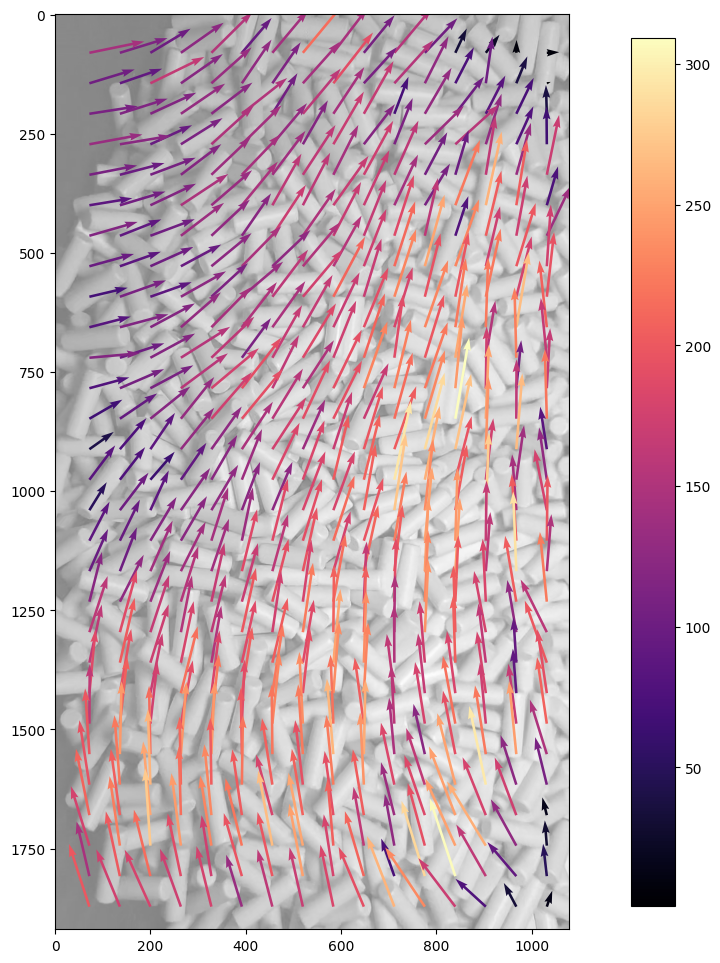

In [44]:
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(image1.mean(axis=2),alpha=0.5,cmap='gray')
h = image1.shape[0]
w = image1.shape[1]
#w-x,h-y
Q= ax.quiver(w-x,h-y,Umean,Vmean,Umean**2+Vmean**2,scale=110,width=.005,cmap='magma')#Reds,virdis,magma
# plt.show()
# plt.plot(np.mean(Umean,axis=1)*30,y[:,0],color='r',lw=10)
# plt.colorbar(Q, orientation='horizontal')
cbar = plt.colorbar(Q, ax=ax, orientation='vertical', fraction=0.07, pad=0.1)
plt.savefig('final.pdf')

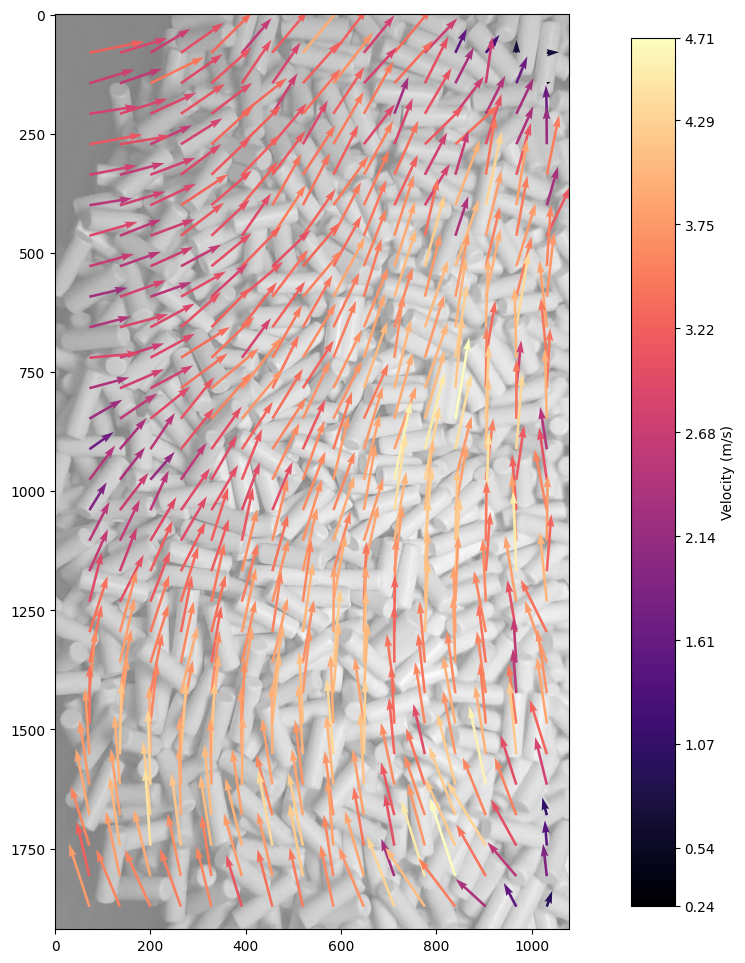

In [52]:
fig, ax = plt.subplots(figsize=(8, 16))
ax.imshow(image1.mean(axis=2), alpha=0.5, cmap='gray')

h = image1.shape[0]
w = image1.shape[1]

vec_field = list(map(lambda row: list(map(math.sqrt, row)), Umean**2 + Vmean**2))
# Plot the quiver
Q = ax.quiver(w-x, h-y, Umean, Vmean, vec_field, scale=110, width=.005, cmap='magma')

# Create the colorbar
cbar = plt.colorbar(Q, ax=ax, orientation='vertical', fraction=0.07, pad=0.1)

# Define the scaling factor
# scaling_factor = 1 / pixel_per_cm * offset / dt # example scaling factor
scaling_factor = 1 * pixel_per_cm / (dt) / 100

vec_max = math.sqrt((Umean**2+Vmean**2).max())
vec_min = math.sqrt((Umean**2+Vmean**2).min())
# Get the colorbar's ticks
ticks = cbar.get_ticks()
ticks[0] = vec_min
ticks[-1] = vec_max
# Apply the scaling factor and update the ticks
# ticks = list(map(math.sqrt, ticks))
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick * scaling_factor:.2f}' for tick in ticks])

# Add the label with units
cbar.set_label('Velocity (m/s)')

# Save the figure
plt.savefig('final_scaled.pdf')

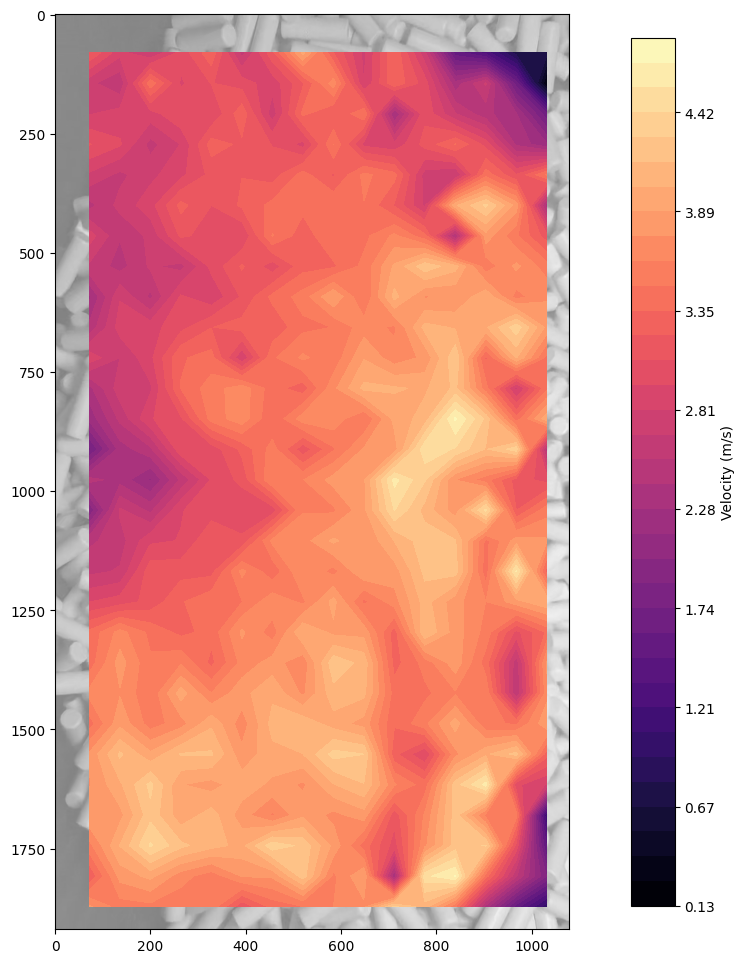

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Umean and Vmean are 2D arrays, and you have image1, x, y defined
fig, ax = plt.subplots(figsize=(8, 16))
ax.imshow(image1.mean(axis=2), alpha=0.5, cmap='gray')

# Calculate the magnitude of the velocity field
velocity_magnitude = np.sqrt(Umean**2 + Vmean**2)

# Create a contour plot
contour = ax.contourf(w-x, h-y, velocity_magnitude, cmap='magma', levels=40)  # Adjust levels as needed

# Create the colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', fraction=0.07, pad=0.1)

# Define the scaling factor
scaling_factor = 1 * pixel_per_cm / (dt) / 100

# Get the colorbar's ticks and apply the scaling factor
ticks = cbar.get_ticks()
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick * scaling_factor:.2f}' for tick in ticks])

# Add the label with units
cbar.set_label('Velocity (m/s)')

# Save the figure
plt.savefig('final_contour_scaled.pdf')
plt.show()


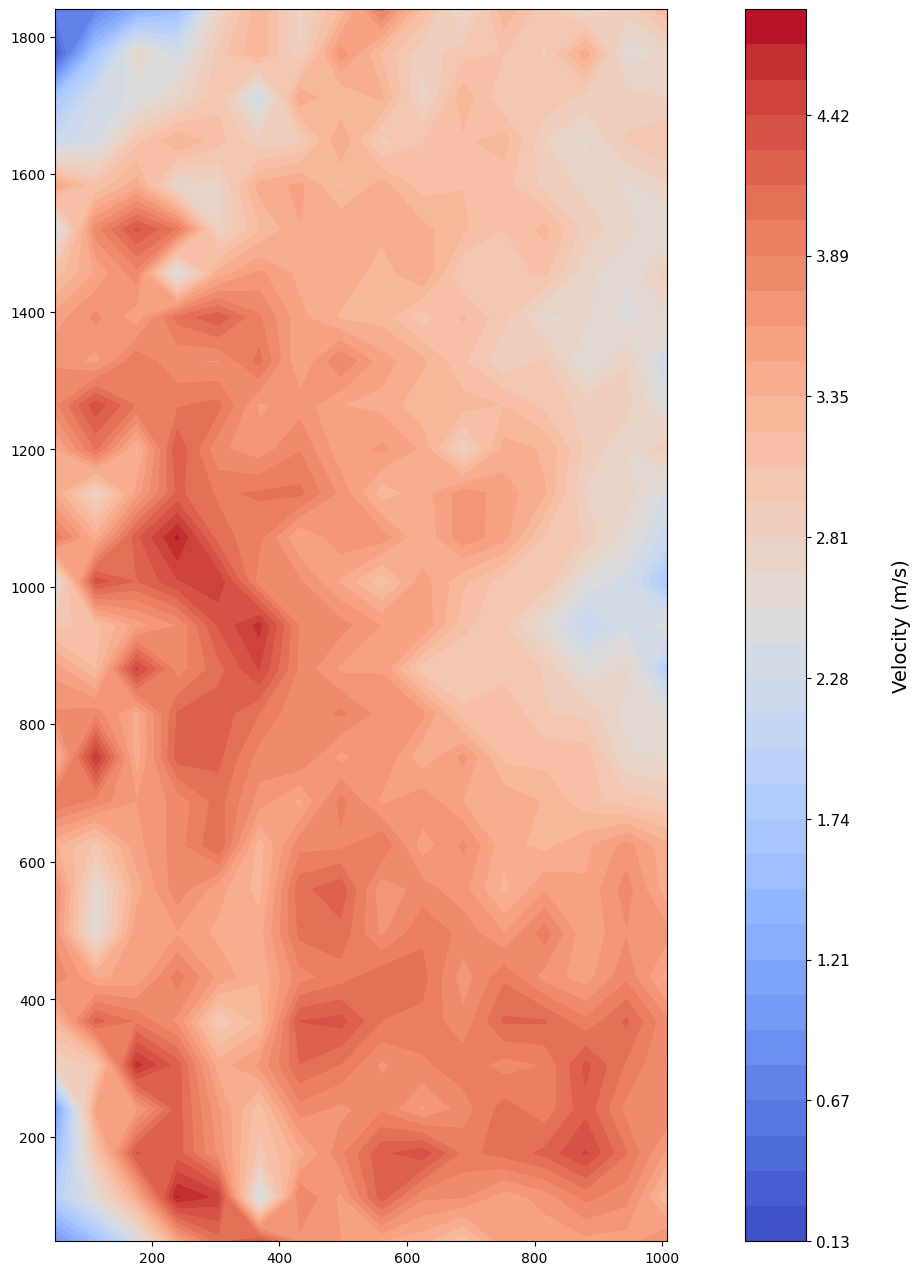

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Calculate the velocity magnitude from Umean and Vmean
velocity_magnitude = np.sqrt(Umean**2 + Vmean**2)

# Create the contour plot
fig, ax = plt.subplots(figsize=(10, 16))
contour = ax.contourf(x, y, velocity_magnitude, cmap='coolwarm',levels=40) #magma,bwr

# Create the colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', fraction=0.11, pad=0.1)

# Define the scaling factor (adjust this according to your data)
scaling_factor = 1 * pixel_per_cm / (dt) / 100

# Apply the scaling factor to the colorbar ticks
ticks = cbar.get_ticks()
# ticks = [math.sqrt(tick) for tick in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick * scaling_factor:.2f}' for tick in ticks])

# Add the label with units
cbar.set_label('Velocity (m/s)', labelpad = 30, fontsize=14)
cbar.ax.tick_params(labelsize=11)

# Save the figure
plt.savefig('final_contour_scaled_without_cascaded.pdf')
